In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip

--2022-03-16 07:46:05--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.36.43
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.36.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘4drtyfjtfy-1.zip’

4drtyfjtfy-1.zip    100%[===================>]  91.16M  22.2MB/s    in 4.1s    

2022-03-16 07:46:10 (22.2 MB/s) - ‘4drtyfjtfy-1.zip’ saved [95592747/95592747]



In [1]:
import os
import torch
import cv2
from torch import nn
import torchvision
from torchvision import transforms as tr
import torchsummary
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!unzip -qq drive/MyDrive/hand_detection.zip -d ./

In [5]:
labels = {
    'left': 0,
    'rigth': 1,
    'forward': 2,
    'backward' : 3,
    'stop' : 4,
    'none' : 5,
}

In [7]:
meta_train = []
meta_valid = []
for root, dirs, filenames in os.walk('hand_detection'):
    if 'train' in root:
        meta = meta_train
    elif 'valid' in root:
        meta = meta_valid
    else:
        continue


    for filename in filenames:
        first, last = os.path.splitext(filename)
        if last != '.jpg':
            continue
        label = -1
        for name in labels:
            if name in filename:
                label = labels[name]
                break
        if label == -1:
            continue
        
        path = os.path.join(root, filename)
        meta.append((path, label))

len(meta_train), len(meta_valid)

(884, 101)

In [22]:
class RandomDitter():
  def __init__(self, sigma):
    self.sigma = sigma
  def __call__(self, input):
    noise = torch.randn(input.shape) * self.sigma
    x = input + noise
    x = torch.clip(x, 0, 255)
    x = x.type(input.dtype)
    return x

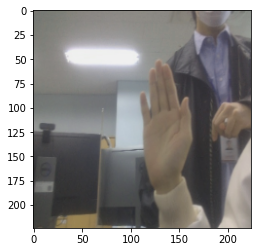

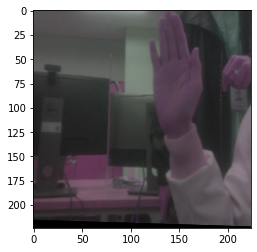

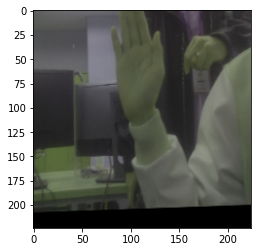

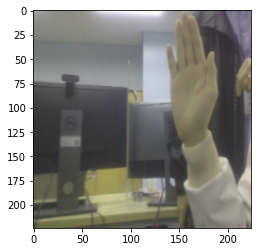

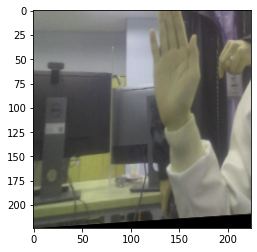

In [24]:


trans_train = tr.Compose([
            tr.Resize((224+ 100, 224+ 100)),
            #tr.RandomHorizontalFlip(),
            tr.RandomPerspective(0.2, p=1),
            tr.RandomCrop((224, 224)),
            tr.RandomGrayscale (p=0.05),
            tr.ColorJitter(brightness= 0.5 ,hue=0.2)
])

trans_valid = tr.Compose([
            tr.Resize((224,224))
])

image = torchvision.io.read_image('/content/hand_detection/train/save_kha/backward_kh_084544.jpg')
for _ in range(5):
  resized = trans_train(image)
  plt.imshow(resized.permute(1, 2, 0))
  plt.show()


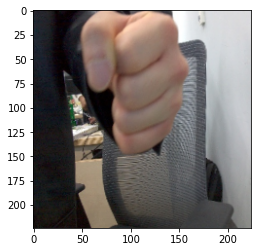

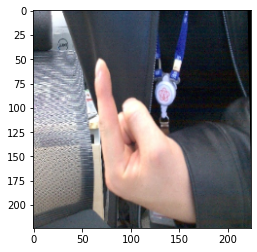

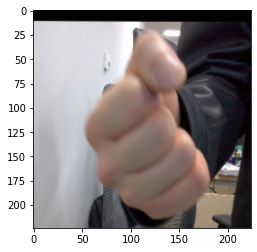

In [11]:
class WeatherDataset(torch.utils.data.Dataset): #me
  def __init__(self, meta, trans): #meta, trans 
    self.meta = meta
    self.trans = trans

  def __len__(self):
    return len(self.meta)

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()

    path, label = self.meta[index] #메타데이터로부터 경로, 라벨
    image = torchvision.io.read_image(path) #
    image = self.trans(image) #augmentation
    image = image.type(torch.float32)

    label = torch.tensor(label, dtype=torch.int64)
    return image, label

dataset_train = WeatherDataset(meta_train, trans_train)
dataset_valid = WeatherDataset(meta_valid, trans_valid)


for i in range(3):
  image, label = dataset_train[i]
  plt.imshow(image.permute(1, 2, 0)/255)
  plt.show()

In [12]:
batch_size = 32
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
                                           shuffle=True, drop_last=True, num_workers=2)

loader_valid = torch.utils.data.DataLoader(dataset_valid,
                                           batch_size = batch_size,
                                           num_workers=2
                                           )
iterator = iter(loader_train)

for _ in range(3):
  image, label = next(iterator)
  print(image.shape, label.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])


In [13]:
pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [14]:
for index,module in enumerate(pretrained.children()): #model 자식들
  print('-------------------------------------')
  print(module)

-------------------------------------
Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [16]:
backbone = list(pretrained.children())[0]
# feature = backbone(torch.zeros(1, 3, 224, 224))
# z = nn.AvgPool2d(7)(feature)
# z = nn.Flatten()(z)
# z = nn.Linear(1280, 4)(z)
# z.shape

head = nn.Sequential(
    nn.AvgPool2d(7),
    nn.Flatten(),
    nn.Linear(1280, 6)
)
class MobilenetScale(nn.Module):
  def __init__(self):
    super().__init__()
    self.trans = tr.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
  def forward(self, input):
    return self.trans(input / 255)
   
model = nn.Sequential(
    MobilenetScale(),
    backbone,
    head
).to(device)

In [ ]:
backbone.requires_grad_(False) #매개변수 고정
opt1 = torch.optim.AdamW(head.parameters())
opt2 = torch.optim.AdamW(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()


In [ ]:
for epoch in range(10):
    if epoch < 5:
        backbone.requires_grad_(False)
        opt = opt1
    else:
        backbone.requires_grad_(True)
        opt = opt2

    model.train()
    for step, (x, y) in enumerate(loader_train):
        logits = model(x.to(device))
        loss = loss_fn(logits, y.to(device)) #scalar
        opt.zero_grad()###############
        loss.backward()
        opt.step()####################

        ###acc
        pred = logits.argmax(axis=1)
        acc = sum(pred == y.to(device)) / len(y)
        print(f'\r {epoch} {step} loss={loss.item():4f}  acc={acc.item():4f}', end='')
    model.eval()
    with torch.no_grad():
        val_loss = []
        val_acc = []
        for x, y in loader_valid:
            logits = model(x.to(device))
            loss = loss_fn(logits, y.to(device))
            pred = logits.argmax(axis=1)
            acc = sum(pred == y.to(device)) / len(y)

            val_loss.append(loss.item())
            val_acc.append(acc.item())
        
        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)
        print(f'    val_loss={val_loss:4f}  val_acc={val_acc:4f}')


 0 6 loss=0.494082  acc=0.812500    val_loss=0.465571  val_acc=0.915250
 1 6 loss=0.315616  acc=0.906250    val_loss=0.319726  val_acc=0.923250
 2 6 loss=0.219109  acc=0.937500    val_loss=0.251474  val_acc=0.919750
 3 6 loss=0.219503  acc=0.968750    val_loss=0.221020  val_acc=0.913500
 4 6 loss=0.220614  acc=0.906250    val_loss=0.210903  val_acc=0.923250
 5 6 loss=1.325864  acc=0.750000    val_loss=1.270796  val_acc=0.796750
 6 6 loss=0.399408  acc=0.843750    val_loss=0.384391  val_acc=0.882250
 7 6 loss=0.277306  acc=0.843750    val_loss=1.019079  val_acc=0.787000
 8 6 loss=0.156349  acc=0.906250    val_loss=1.206715  val_acc=0.804000
 9 6 loss=0.139982  acc=0.906250    val_loss=0.784740  val_acc=0.818250


In [ ]:
image = cv2.imread('/content/다운로드.jpg')
resized = cv2.resize(image, (224, 224))
input = resized.transpose(2, 0, 1).astype(np.float32)[None]
input.shape

(1, 3, 224, 224)

In [ ]:
with torch.no_grad():
    model.eval()
    logits = model(torch.tensor(input).to(device))
nn.Softmax(dim=1)(logits)


tensor([[9.9997e-01, 3.4907e-05]], device='cuda:0')